# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Servo analysis

In this assignment, you will continue the analysis we started in class of the Servo dataset.

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [2]:
# Load the data
servo_df = spark.createDataFrame(pd.read_csv('servo.data',
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe

Create a dataframe `servo_sample_df` with the first 20 rows of `servo_df`

In [164]:
# create `servo_sample_df`
servo_sample_df = servo_df.limit(20)
servo_sample_df.take(10)
#raise NotImplementedError()

[Row(motor='E', screw='E', pgain=5, vgain=4, rise_time=0.28125095),
 Row(motor='B', screw='D', pgain=6, vgain=5, rise_time=0.5062525),
 Row(motor='D', screw='D', pgain=4, vgain=3, rise_time=0.35625148),
 Row(motor='B', screw='A', pgain=3, vgain=2, rise_time=5.500033),
 Row(motor='D', screw='B', pgain=6, vgain=5, rise_time=0.35625148),
 Row(motor='E', screw='C', pgain=4, vgain=3, rise_time=0.8062546),
 Row(motor='C', screw='A', pgain=3, vgain=2, rise_time=5.100014),
 Row(motor='A', screw='A', pgain=3, vgain=2, rise_time=5.7000422),
 Row(motor='C', screw='A', pgain=6, vgain=5, rise_time=0.76875436),
 Row(motor='D', screw='A', pgain=4, vgain=1, rise_time=1.0312537)]

In [5]:
# 2 pts - right number of rows
np.testing.assert_equal(servo_sample_df.count(), 20)

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `motor` vs `rise_time`

<AxesSubplot:xlabel='rise_time', ylabel='motor'>

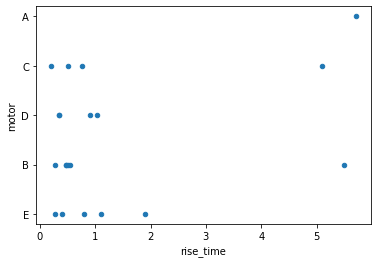

In [9]:
servo_sample_df.toPandas().plot(x='rise_time', y='motor', kind='scatter')
#raise NotImplementedError()

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `screw` vs `rise_time`

<AxesSubplot:xlabel='rise_time', ylabel='screw'>

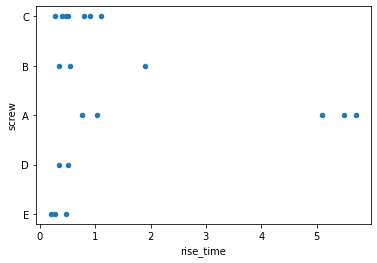

In [11]:
servo_sample_df.toPandas().plot(x='rise_time', y='screw', kind='scatter')
#raise NotImplementedError()

## Perform correlations between vgain-rise time, pgain-rise time, and vgain-pgain

Create a `servo_corr_df` dataframe that contains the correlations between `vgain` and `rise_time` as a column `corr_vgain_rise_time`, between `pgain` and `rise_time` as `corr_pgain_rise_time`, and `vgain` and `pgain` as `corr_vgain_pgain`.

In [70]:
# create `servo_corr_df` here
servo_corr_df = servo_df.select(fn.corr('vgain', 'rise_time').alias('corr_vgain_rise_time'),
                                fn.corr('pgain', 'rise_time').alias('corr_pgain_rise_time'),
                               fn.corr('vgain', 'pgain').alias('corr_vgain_pgain'))

# YOUR CODE HERE
#raise NotImplementedError()

+--------------------+--------------------+------------------+
|corr_vgain_rise_time|corr_pgain_rise_time|  corr_vgain_pgain|
+--------------------+--------------------+------------------+
|-0.36438266626914595| -0.5981287119612233|0.8122683058183873|
+--------------------+--------------------+------------------+



In [71]:
## 7 pts
np.testing.assert_equal(set(servo_corr_df.columns), 
                        {'corr_pgain_rise_time', 'corr_vgain_pgain', 'corr_vgain_rise_time'})
np.testing.assert_almost_equal(list(servo_corr_df.first().asDict().values()),
                               [-0.36438266626914595, -0.5981287119612234, 0.8122683058183874], decimal=3)

## Compute mean rise_time for different motors and screws

Create `motor_rise_time_df` with the column `motor` and `avg_rise_time`, where `avg_rise_time` is the average rise time for a motor. Sort the resulting dataframe from highest to lowest average rise time.

In [113]:
# YOUR CODE HERE
motor_rise_time_df = servo_df.groupBy("motor").agg(fn.avg("rise_time").alias("avg_rise_time"))
motor_rise_time_df= motor_rise_time_df.orderBy('avg_rise_time', ascending=False)
#raise NotImplementedError()

In [114]:
# 3 pts
np.testing.assert_array_almost_equal(
    (motor_rise_time_df.orderBy('motor').select('avg_rise_time').\
     rdd.map(lambda x: list(x.asDict().values())).collect())
    ,
[[1.761110668888889],
 [1.6819423677777776],
 [1.2540610067499998],
 [0.9176125145454546],
 [1.144893208181818]], decimal=3)

Create `screw_rise_time_df` with the column `screw` and `avg_rise_time` sorted from highest to lowest average rise time.

In [117]:
# YOUR CODE HERE
screw_rise_time_df = servo_df.groupBy("screw").agg(fn.avg("rise_time").alias("avg_rise_time"))
screw_rise_time_df= screw_rise_time_df.orderBy('avg_rise_time', ascending=False)
#raise NotImplementedError()

In [118]:
# 3 pts
np.testing.assert_array_almost_equal(
    (screw_rise_time_df.orderBy('screw').select('avg_rise_time').\
     rdd.map(lambda x: list(x.asDict().values())).collect())
    ,
       [[1.768461212142857],
 [1.3919625091428571],
 [1.2485862280645161],
 [1.1612471173333332],
 [1.225643291724138]],
decimal=3)

# Feature engineering

## Dummy variables for motors and screws
Create a dataframe `dummy_df` with columns `motor` and `screw` as dummy variables, and columns `vgain`, `pgain`, and `rise_time`. Use motor D and screw C as the baselines and name the dummy variables `motor_A` for motor `A` and so on. Follow a similar pattern for screw. The dataframe `dummy_df` should not contain the columns `motor` and `screw` but only their dummy variable representations. **All column types should be float or integer.**

In [185]:
# create dummy_df below
# YOUR CODE HERE
pd_servo_df = servo_df.toPandas()
dummy_df = pd.get_dummies(pd_servo_df, prefix=['motor', 'screw'],drop_first=False)
dummy_df = spark.createDataFrame(dummy_df)
dummy_df = dummy_df.withColumn("pgain", fn.col("pgain").cast("int"))
dummy_df = dummy_df.withColumn("vgain", fn.col("vgain").cast("int"))
dummy_df = dummy_df.withColumn("rise_time", fn.col("rise_time").cast("float"))
dummy_df = dummy_df.withColumn("motor_A", fn.col("motor_A").cast("int"))
dummy_df = dummy_df.withColumn("motor_B", fn.col("motor_B").cast("int"))
dummy_df = dummy_df.withColumn("motor_C", fn.col("motor_C").cast("int"))
dummy_df = dummy_df.withColumn("motor_E", fn.col("motor_E").cast("int"))
dummy_df = dummy_df.withColumn("screw_A", fn.col("screw_A").cast("int"))
dummy_df = dummy_df.withColumn("screw_B", fn.col("screw_B").cast("int"))
dummy_df = dummy_df.withColumn("screw_D", fn.col("screw_D").cast("int"))
dummy_df = dummy_df.withColumn("screw_E", fn.col("screw_E").cast("int"))
dummy_df = dummy_df.drop("motor_D","screw_C")
#raise NotImplementedError()

NameError: name 'columns' is not defined

In [174]:
# 3 pts
np.testing.assert_equal(len(dummy_df.columns), 11)
np.testing.assert_equal(dummy_df.select(fn.sum('motor_A')).first()['sum(motor_A)'], 36)
np.testing.assert_equal(dummy_df.select(fn.sum('screw_A')).first()['sum(screw_A)'], 42)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [175]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  98
# points in validation:  52
# points in testing:  17


## Propose three regression models

In the next section, you will choose the best model to explain the data in `servo_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `pgain`

Create a pipeline that takes *pgain* as a feature to predict *rise time* and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df` in which the raw feature `pgain` may or may not have been feature engineered. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [180]:
# create `pipe_model1` below
va = feature.VectorAssembler(inputCols=['pgain'], outputCol='features')
lr = regression.LinearRegression(featuresCol='features', labelCol='rise_time')
pipe = Pipeline(stages=[va, lr])
pipe_model1 = pipe.fit(training_df)
#raise NotImplementedError()

In [181]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with only `vgain`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [182]:
# YOUR CODE HERE
va2 = feature.VectorAssembler(inputCols=['vgain'], outputCol='features')
lr2 = regression.LinearRegression(featuresCol='features', labelCol='rise_time')
pipe2 = Pipeline(stages=[va2, lr2])
pipe_model2 = pipe2.fit(training_df)
#raise NotImplementedError()

In [183]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (1,))

### Model 3: Fit model with only motor, screw, pgain, and vgain

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: motor, screw, pgain, and vgain. Choose the columns from `dummy_df` appropriately.

In [186]:
# create `pipe_model3` below
va3 = feature.VectorAssembler(inputCols=['vgain','pgain', 'motor_A', 'motor_B', 'motor_C', 'motor_E', 
                                        'screw_A', 'screw_B', 'screw_D', 'screw_E'], outputCol='features')
lr3 = regression.LinearRegression(featuresCol='features', labelCol='rise_time')
pipe3 = Pipeline(stages=[va3, lr3])
pipe_model3 = pipe3.fit(training_df)

# YOUR CODE HERE
#raise NotImplementedError()

In [187]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (10,))

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only with column `rmse`

In [193]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
# YOUR CODE HERE
rmse = fn.sqrt(fn.mean((fn.col('rise_time') - fn.col('prediction'))**2)).alias('rmse')

rmse1_df = pipe_model1.transform(validation_df).select(rmse)
rmse2_df = pipe_model2.transform(validation_df).select(rmse)
rmse3_df = pipe_model3.transform(validation_df).select(rmse)
#raise NotImplementedError()

In [194]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+-----------------+
|             rmse|
+-----------------+
|1.251347996368173|
+-----------------+

+------------------+
|              rmse|
+------------------+
|1.4596207909749874|
+------------------+

+-----------------+
|             rmse|
+-----------------+
|1.036997099105056|
+-----------------+



In [195]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [196]:
# assign best model (the best pipeline transformer) to a variable best_model below
best_model = pipe_model3
#raise NotImplementedError()

In [197]:
# (2 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [198]:
# create rmse_best_df
rmse_best_df = rmse3_df
#raise NotImplementedError()

In [199]:
# (3 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

**(3 pts)** What is the best estimated generalization performance of the best model? Answer in the cell below

In [201]:
# YOUR CODE HERE
rmse_best_df.show()
#raise NotImplementedError()

+-----------------+
|             rmse|
+-----------------+
|1.036997099105056|
+-----------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `dummy_df`).

In [202]:
# create `pipe_model_best` below
pipe_model_best = pipe3.fit(dummy_df)
#raise NotImplementedError()

In [203]:
# (4 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[1].coefficients.shape, (10,))

**(4 pts)** Assume that all features on `dummy_df` were comparable (i.e., standardized). Taking motor D and screw C as the baseline, what are the top 2 most important features for *increasing rise time* and the top 2 most important features for *decreasing rise time*? Answer below with code and comments to support your answer

In [204]:
# YOUR CODE HERE
pipe_model_best.stages[1].coefficients
#motor A and B are the top 2 most important features for increasing rise time
#vgain and screw_D are the top 2 most important features for decreasing rise time
#raise NotImplementedError()

DenseVector([0.567, -1.6435, 1.4303, 1.3511, 1.1637, 0.7439, 1.0825, 0.3618, -0.123, -0.0832])